In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

import seaborn as sns
import os

sns.set()

In [2]:
# load Santa Claus point cloud (the so called "Santa Cloud")
files = [f for f in os.listdir("data/Santa_Claus/point_cloud") if ".txt" in f]

df = pd.concat([pd.read_csv("data/Santa_Claus/point_cloud/"+f,sep = " ", header = None) for f in files])
df.columns = "x y z r g b light_x light_y light_z".split()
df.index = np.arange(len(df))

In [4]:
df.head().append(df.tail())

,x,y,z,r,g,b,light_x,light_y,light_z
0,0.169497,-0.820906,0.098365,75,75,75,0.093784,0.993204,0.068925
1,0.193142,-0.824134,0.082063,75,75,75,0.338302,0.940298,0.037303
2,0.186871,-0.823192,0.086588,75,75,75,0.297652,0.952229,0.068292
3,0.163850,-0.819579,0.103571,75,75,75,0.179098,0.959170,0.218898
4,0.177354,-0.821965,0.092982,75,75,75,0.183266,0.981011,0.063484
989318,0.203953,-0.833493,0.059230,86,86,86,0.077873,0.938433,-0.336569
989319,0.200565,-0.830946,0.065511,86,86,86,-0.094327,0.917294,-0.386877
989320,0.206821,-0.836583,0.051930,86,86,86,0.537521,0.832054,-0.136958
989321,0.207484,-0.835227,0.054638,86,86,86,-0.021838,0.931324,-0.363537
989322,0.195055,-0.828143,0.072882,86,86,86,0.024428,0.932136,-0.361283


In [58]:
# select a sample
np.random.seed(95)

sample_size = 5000
df_sample = df.loc[np.random.choice(len(df), sample_size, replace = False),:]
df_sample.index = np.arange(len(df_sample))

## Different ways to color the "Santa Cloud"

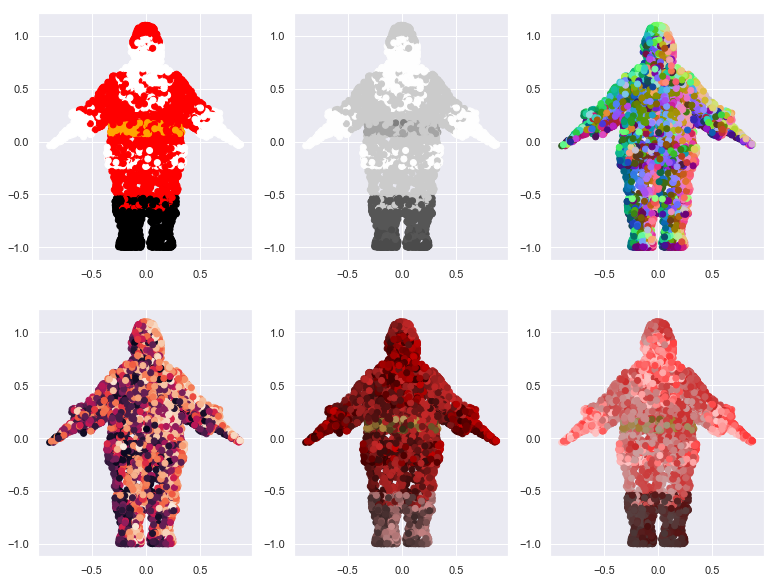

In [39]:
colors = {
    204 : "red",
    255 : "white",
    86 : "black",
    165 : "orange",
    75 : "black",
    127 : "orange",
}

hue = dict()
for k in colors: hue[k] = mcolors.rgb_to_hsv(mcolors.to_rgb(colors[k]))[0]


plt.figure(figsize = (13,10))

plt.subplot(2,3,1)
plt.scatter(df_sample.x,df_sample.y, c = [colors[a] for a in df_sample.r])

plt.subplot(2,3,2)
plt.scatter(df_sample.x,df_sample.y, c = df_sample[["r","g","b"]].values/256)

plt.subplot(2,3,3)
plt.scatter(df_sample.x,df_sample.y, c = df_sample[["light_x","light_y","light_z"]].values/2+0.5)

plt.subplot(2,3,4)
plt.scatter(df_sample.x,df_sample.y, c = df_sample[["light_x","light_y","light_z"]].mean(axis = 1).values/2+0.5)

plt.subplot(2,3,5)
brightness = df_sample[["light_x","light_y","light_z"]].mean(axis = 1)/2+0.5
sat = df_sample[["r","g","b"]].mean(axis = 1)/256
c = [mcolors.hsv_to_rgb((hue[df_sample.loc[i,"r"]], sat[i], brightness[i] )) for i in df_sample.index]
plt.scatter(df_sample.x,df_sample.y, c = c)

plt.subplot(2,3,6)
sat = df_sample[["light_x","light_y","light_z"]].mean(axis = 1)/2+0.5
brightness = df_sample[["r","g","b"]].mean(axis = 1)/256
c = [mcolors.hsv_to_rgb((hue[df_sample.loc[i,"r"]], sat[i], brightness[i] )) for i in df_sample.index]
plt.scatter(df_sample.x,df_sample.y, c = c)


plt.show()

## Show me some perspective

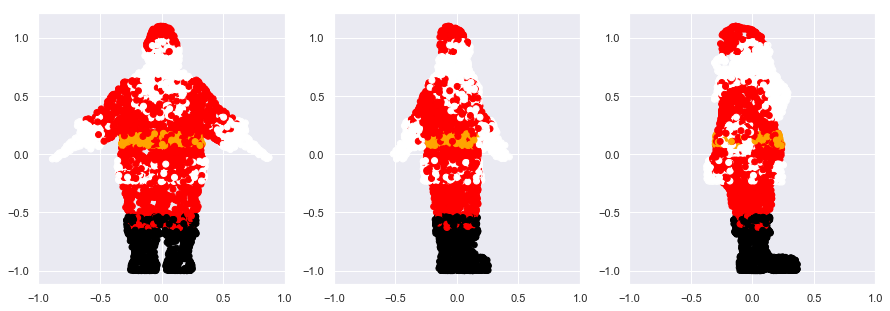

In [48]:
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.scatter(df_sample.x,df_sample.y, c = [colors[a] for a in df_sample.r])
plt.xlim(-1,1)

plt.subplot(1,3,2)
plt.scatter((df_sample.x+df_sample.z)/2,df_sample.y, c = [colors[a] for a in df_sample.r])
plt.xlim(-1,1)

plt.subplot(1,3,3)
plt.scatter(df_sample.z,df_sample.y, c = [colors[a] for a in df_sample.r])
plt.xlim(-1,1)

plt.show()

# Mapper

In [49]:
# tmp
import sys
sys.path.append("../giotto-learn/giotto")
import mapper as mp
from mapper.visualize import *

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN,hierarchical
import networkx as nx
import plotly.graph_objects as go
from tqdm import tqdm

In [50]:
X = df_sample[["x","y","z"]].values

## Filter function: Identity 

In [51]:
pipeline = mp.mapper.make_mapper_pipeline(filter_func = None,
                                          cover=mp.cover.CubicalCover(n_intervals = 20, overlap_frac = 0.25),
                                          verbose=True,
                                         )

graph = pipeline.fit_transform(X)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.4s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.4s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   2.3s
[Pipeline] ............. (step 3 of 3) Processing nerve, total= 1.0min


In [76]:
# plot
node_elements = nx.get_node_attributes(graph, 'elements')

pos = dict()
node_colors = []
i=0
for n in node_elements.keys(): 
    pos[n] = X[node_elements[n]].mean(axis = 0)
    node_colors.append(colors[df_sample.loc[node_elements[n],"r"].value_counts().index[0]])
    i+=1
#pos = nx.spring_layout(graph, seed=0, dim=3)
#pos = nx.kamada_kawai_layout(graph, dim = 3)
#pos = nx.layout.spectral_layout(graph, dim = 3)


node_text = [k for k in node_elements.keys()]
node_sizes = [len(el) for el in node_elements.values()]

fig = mp.visualize.create_network_3d(graph, 
                                    pos, 
                                    [20]*len(node_sizes),#node_sizes, 
                                    node_colors, 
                                    node_text, 
                                    node_scale=12)


fig.update_layout(width=700,height=700,margin=go.layout.Margin(t=20,l=200,r=50))
fig.show()

## Filter function: Vertical axis

In [108]:
pipeline = mp.mapper.make_mapper_pipeline(filter_func = mp.filter.Projection(column_indices=1),
                                          cover=mp.cover.OneDimensionalCover(n_intervals = 200, overlap_frac = 0.25),
                                          verbose=True,
                                         )

graph = pipeline.fit_transform(X)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.1s


In [109]:
# plot
node_elements = nx.get_node_attributes(graph, 'elements')

pos = dict()
node_colors = []
i=0
for n in node_elements.keys(): 
    pos[n] = X[node_elements[n]].mean(axis = 0)
    node_colors.append(colors[df_sample.loc[node_elements[n],"r"].value_counts().index[0]])
    i+=1
#pos = nx.spring_layout(graph, seed=0, dim=3)
#pos = nx.kamada_kawai_layout(graph, dim = 3)
#pos = nx.layout.spectral_layout(graph, dim = 3)


node_text = [k for k in node_elements.keys()]
node_sizes = [len(el) for el in node_elements.values()]

fig = mp.visualize.create_network_3d(graph, 
                                    pos, 
                                    [20]*len(node_sizes),#node_sizes, 
                                    node_colors, 
                                    node_text, 
                                    node_scale=12)


fig.update_layout(width=700,height=700,margin=go.layout.Margin(t=20,l=200,r=50))
fig.show()

## Filter function: Centrality

In [114]:
pipeline = mp.mapper.make_mapper_pipeline(filter_func = mp.filter.Eccentricity(1),
                                          cover=mp.cover.OneDimensionalCover(n_intervals = 300, overlap_frac = 0.35),
                                          verbose=True,
                                         )

graph = pipeline.fit_transform(X)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.2s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   1.3s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.3s


In [115]:
# plot
node_elements = nx.get_node_attributes(graph, 'elements')

pos = dict()
node_colors = []
i=0
for n in node_elements.keys(): 
    pos[n] = X[node_elements[n]].mean(axis = 0)
    node_colors.append(colors[df_sample.loc[node_elements[n],"r"].value_counts().index[0]])
    i+=1
#pos = nx.spring_layout(graph, seed=0, dim=3)
#pos = nx.kamada_kawai_layout(graph, dim = 3)
#pos = nx.layout.spectral_layout(graph, dim = 3)


node_text = [k for k in node_elements.keys()]
node_sizes = [len(el) for el in node_elements.values()]

fig = mp.visualize.create_network_3d(graph, 
                                    pos, 
                                    [20]*len(node_sizes),#node_sizes, 
                                    node_colors, 
                                    node_text, 
                                    node_scale=12)


fig.update_layout(width=700,height=700,margin=go.layout.Margin(t=20,l=200,r=50))
fig.show()